In [5]:
import pandas as pd
from astropy.coordinates import SkyCoord, GeocentricMeanEcliptic
import astropy.units as u
from io import StringIO
import sys
import re
from astropy.time import Time
import datetime
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, GCRS, get_body
import math
import matplotlib.pyplot as plt
import numpy as np

In [100]:
def get_az(row):
    '''
    This function takes in a row of the unparsed dataframe, and returns the azimuth of the planetary object
    based on that data
    ''' 
    ##converting to astropy SkyCoordinates
    ra = row["ra"]
    dec = row["dec"]
    ra_formatted = ra.split()[0] + "h" + ra.split()[1] + "m" + ra.split()[2] + "s"
    dec_formatted = dec.split()[0] + "d" + dec.split()[1] + "m" + dec.split()[2] + "s"
    c = SkyCoord(ra_formatted, dec_formatted, frame='icrs')
    
    ##Determining earth location from which azimuth is to be calculated - currently height is hardcoded at each
    ##location so that predictions will solely be based on latitude and longitude
    lon = row["CenterLon"]
    lat = row["CenterLat"]
    earth_loc = EarthLocation(lat=lat, lon=lon, height=400*u.m)
    
    ##Parse datetime object
    time = row["time"]
    datetime_obj = datetime.datetime.strptime(time.strip(), '%Y-%b-%d %H:%M')
    time = Time(str(datetime_obj))
    
    ##Use earth location and datetime to transform to alt/az coords
    c_horiz = c.transform_to(AltAz(obstime=time,location=earth_loc))
    return (c_horiz.az *u.deg).value

def get_alt(row):
    '''
    This function takes in a row of the unparsed dataframe, and returns the altitude of the planetary object
    based on that data
    ''' 
    ##converting to astropy SkyCoordinates
    ra = row["ra"]
    dec = row["dec"]
    ra_formatted = ra.split()[0] + "h" + ra.split()[1] + "m" + ra.split()[2] + "s"
    dec_formatted = dec.split()[0] + "d" + dec.split()[1] + "m" + dec.split()[2] + "s"
    c = SkyCoord(ra_formatted, dec_formatted, frame='icrs')
    
    ##Determining earth location from which azimuth is to be calculated - currently height is hardcoded at each
    ##location so that predictions will solely be based on latitude and longitude
    lon = row["CenterLon"]
    lat = row["CenterLat"]
    earth_loc = EarthLocation(lat=lat, lon=lon, height=400*u.m)
    
    ##Parse datetime object
    time = row["time"]
    datetime_obj = datetime.datetime.strptime(time.strip(), '%Y-%b-%d %H:%M')
    time = Time(str(datetime_obj))
        
    ##Use earth location and datetime to transform to alt/az coords
    c_horiz = c.transform_to(AltAz(obstime=time,location=earth_loc))
    return (c_horiz.alt *u.deg).value

def get_dist(row):
    '''
    This function takes in a row of the unparsed dataframe, and returns the distance of the planetary object
    from the planet that column is describing
    ''' 
    ##converting to astropy SkyCoordinates
    ra = row["ra"]
    dec = row["dec"]
    ra_formatted = ra.split()[0] + "h" + ra.split()[1] + "m" + ra.split()[2] + "s"
    dec_formatted = dec.split()[0] + "d" + dec.split()[1] + "m" + dec.split()[2] + "s"
    c = SkyCoord(ra_formatted, dec_formatted, frame='gcrs')
    
    lon = row["CenterLon"]
    lat = row["CenterLat"]
    earth_loc = EarthLocation(lat=lat, lon=lon, height=400*u.m)
    time = row["time"]
    datetime_obj = datetime.datetime.strptime(time.strip(), '%Y-%b-%d %H:%M')
    time = Time(str(datetime_obj))
    
    ##using astropy functions to get the seperation in AU between the two bodies at the given time and location
    planet = get_body(row["Planet"].lower(), time)
    earth = get_body('earth', time, earth_loc)
    return earth.separation_3d(planet)

def get_earth_loc(row):
    '''
    This function takes in a row of the unparsed dataframe, and returns the geocentric XYZ location of the 
    earth location from which that row's measurements are centered
    ''' 
    ##calculating earthlocation and time
    lon = row["CenterLon"]
    lat = row["CenterLat"]
    earth_loc = EarthLocation(lat=lat, lon=lon, height=400*u.m)
    time = row["time"]
    datetime_obj = datetime.datetime.strptime(time.strip(), '%Y-%b-%d %H:%M')
    time = Time(str(datetime_obj))
    
    ##using astropy get_body function to get the cartesian xyz coordinates centered from earth_loc
    earth = get_body('earth', time, earth_loc)
    return (earth.cartesian.x, earth.cartesian.y, earth.cartesian.z)


def get_planet_loc(row):
    '''
    This function takes in a row of the unparsed dataframe, and returns the geocentric XYZ location of the 
    planet for that row centered at the center of the earth.
    ''' 
    lon = row["CenterLon"]
    lat = row["CenterLat"]
    earth_loc = EarthLocation(lat=lat, lon=lon, height=400*u.m)
    time = row["time"]
    datetime_obj = datetime.datetime.strptime(time.strip(), '%Y-%b-%d %H:%M')
    time = Time(str(datetime_obj))
    planet = get_body(row["Planet"].lower(), time)
    return (planet.cartesian.x, planet.cartesian.y, planet.cartesian.z)

In [93]:
##construct name dictionaries
##parsing the output{i}_{j}.txt files to get a mapping from index to planet
##output stored in the num_to_planet dictionary
##invalid_loc is a set of invalid locations (locations that have unparsable data) used to remove those rows from the data
invalid_loc = set()

##num_to_planet (dict: int->String)
num_to_planet = {}
for i in range(1, 9):
    output_filename = f"output{i}_{1}.txt"
    f = open(output_filename, "r")
    string = f.read()
    string = string.replace("\\n", "").replace("\\r", "\n")
    string = string.split("\n")
    if i != 9:
        num_to_planet[i] = string[1].split()[4]
    else:
        num_to_planet[i] = string[1].split()[5]
    f.close()

##parsing the output{i}_{j}.txt files to get a mapping from index to location name
##num_to_location (dict: int->String)
num_to_location = {}
for i in range(1, 999):
    output_filename = f"output{1}_{i}.txt"
    f = open(output_filename, "r")
    string = f.read()
    string = string.replace("\\n", "").replace("\\r", "\n")
    string = string.split("\n");
    
    r = re.compile("^Center-site name")
    newlist = list(filter(r.match, string))
    if newlist:
        placeline = newlist[0].split()
        name = ""
        for j in range(2, len(placeline)):
            name = name + placeline[j]
        name = name.replace(",", " ")
        num_to_location[i] = name
    else:
        invalid_loc.add(i)
    f.close()

##parsing the output{i}_{j}.txt files to get a mapping from index to planet longitude and latitude
##num_to_position (dict: int->Tuple(double, double))
num_to_position = {}
for i in range(1, 999):
    output_filename = f"output{1}_{i}.txt"
    f = open(output_filename, "r")
    string = f.read()
    string = string.replace("\\n", "").replace("\\r", "\n")
    string = string.split("\n");
    r = re.compile("^Center geodetic")
    newlist = list(filter(r.match, string))
    if newlist:
        lon = newlist[0].split()[3].split(",")[0]
        lat = newlist[0].split()[3].split(",")[1]
        num_to_position[i] = (lon, lat)
    else:
        invalid_loc.add(i)


In [9]:
print(num_to_location)

{1: 'Crowborough', 2: 'Rayleigh', 3: 'Montpellier', 4: 'Toulouse', 5: 'Meudon', 6: 'FabraObservatory Barcelona', 7: 'Paris', 8: 'Algiers-Bouzareah', 9: 'Berne-Uecht', 10: 'Caussols', 11: 'Wetzikon', 12: 'Uccle', 13: 'Leiden', 14: 'Marseilles', 15: 'Utrecht', 16: 'Besancon', 17: 'HoherList', 18: 'Dusseldorf-Bilk', 19: 'Neuchatel', 20: 'Nice', 21: 'Karlsruhe', 22: 'PinoTorinese', 23: 'Wiesbaden', 24: 'Heidelberg-Konigstuhl', 25: 'Stuttgart', 26: 'Berne-Zimmerwald', 27: 'Milan', 28: 'Wurzburg', 29: 'Hamburg-Bergedorf', 30: 'ArcetriObservatory Florence', 31: 'Sonneberg', 32: 'Jena', 33: 'KarlSchwarzschildObs. Tautenburg', 34: 'MonteMarioObservatory Rome', 35: 'Copenhagen', 36: 'CastelGandolfo', 37: 'ColluraniaObservatory Teramo', 38: 'Trieste', 39: 'Lund', 40: 'LohrmannInstitute Dresden', 41: 'Innsbruck', 42: 'Potsdam', 43: 'AsiagoAstrophysicalObs. Padua', 44: 'CapodimonteObservatory Naples', 45: 'Vienna(since1879)', 46: 'KletObservatory CeskeBudejovice', 47: 'Poznan', 48: 'HradecKralove',

In [131]:
def generate_df(num_locations, num_days=5, time_step=1, planet=[], location=[]):
    ##creates a list of strings which correspond to rows of the dataframe to be passed to
    ##pd.dataframe
    final_string = []
    for i in range(1, 9):
        if planet:
            if i not in planet:
                continue
        for j in range(1, num_locations):
            if location:
                if j not in location:
                    continue
            if j in invalid_loc:
                continue
            output_filename = f"output{i}_{j}.txt"
            f = open(output_filename, "r")
            string = f.read()
            string = string.replace("\\n", "").replace("\\r", "\n")
            string = string.split("\n")
            if (final_string == []):
                categories_ind = -1
                for index, elem in enumerate(string):
                    if elem.find("Date__(UT)__HR:MN") != -1:
                        categories_ind = index
                        break
                if categories_ind != -1:
                    final_string = [string[categories_ind] + ",Planet, CenterName, CenterLon, CenterLat"]
            data_ind = -1
            for index, elem in enumerate(string):
                if elem.find("Date__(UT)__HR:MN") != -1:
                    data_ind = index + 1
                    break
            if data_ind != -1:
                string = string[data_ind:data_ind + (num_days * time_step):time_step]
                string = [x + "," + num_to_planet[i] + "," + num_to_location[j] + "," + num_to_position[j][0] + "," + num_to_position[j][1] for x in string if len(x.split(",")) == 13]
                final_string += string
                
    ##clean data - get rid of uncessary columns and call helper functions to convert data into different formats
    df = pd.DataFrame([x.split(',') for x in final_string[1:]], columns=[x for x in final_string[0].split(',')])
    df.drop([df.columns[1], df.columns[2], df.columns[6], df.columns[7], df.columns[8], df.columns[9], df.columns[10], df.columns[11], df.columns[12]], axis=1, inplace=True)
    df.columns = [x.strip() for x in df.columns]
    df = df.rename(columns={"Date__(UT)__HR:MN" : "time","R.A._(ICRF)": "ra", "DEC__(ICRF)": "dec"})
    df['az'] = df.apply(lambda row: get_az(row), axis = 1)
    df['alt'] = df.apply(lambda row: get_alt(row), axis = 1)
    df['dist (center to planet AU)'] = df.apply(lambda row: get_dist(row), axis = 1)
    df['Center_XYZ (Geocentric AU)'] = df.apply(lambda row: get_earth_loc(row), axis = 1)
    df['Planet_XYZ (Geocentric AU)'] = df.apply(lambda row: get_planet_loc(row), axis = 1)

    ##Adding additional event features
    planet_events = pd.read_csv('planets.csv', skiprows=1)
    planet_events.columns = ['Year', 'Month', 'Date', 'Day', 'Time', 'Event', 'NaNdos']
    planet_events['Year'] = planet_events['Year'].fillna(method='ffill').astype(int).astype(str)
    planet_events['Month'] = planet_events['Month'].fillna(method='ffill')
    planet_events['Date'] = planet_events['Date'].astype(str)
    planet_events['Datetime'] = planet_events['Month'] + ' ' + planet_events['Date'] + ' ' + planet_events['Year']
    planet_events['Datetime'] = pd.to_datetime(planet_events['Datetime'])
    dummies = pd.get_dummies(planet_events['Event'])
    dummy_cols = ['Mercury Superior Conj.', 'Mercury Inferior Conj.', 'Venus Inferior Conj.', 'Venus Superior Conj.','Uranus Conjunction', 'Neptune Conjunction', 'Saturn Conjunction', 'Jupiter Conjunction', 'Mars Conjunction', 'Neptune Opposition', 'Saturn Opposition', 'Jupiter Opposition', 'Uranus Opposition', 'Mars Opposition']
    dummy_cols += list(set(planet_events[planet_events['Event'].str.contains('Eclipse')]['Event'].tolist()))
    dummy_cols += list(set(planet_events[planet_events['Event'].str.contains('|'.join(['Solstice', 'Equinox', 'Aphelion', 'Perihelion']))]['Event'].tolist()))
    dummies = dummies[dummy_cols]
    dummies = pd.concat([planet_events[['Datetime']], dummies], axis=1)
    dummies = dummies.groupby(['Datetime']).sum().reset_index()
    df['Datetime'] = pd.to_datetime(df['time'])
    everything = pd.merge(df, dummies, on='Datetime', how='left')
    everything = everything.fillna(0)
    everything
    return everything

In [158]:
def drop_unobservable(df, apmag_thresh=6.5):
    '''
    This function takes in a dataframe generated using the generate_df function, and returns a copy with
    rows corresponding to observations that could not be observed with the human eye due to being above 
    the apparent magnitude that is observable by the naked human eye.
    
    Accepted value of apparent magnitude threshold for visibility is 6.5 or below
    Source: https://en.wikipedia.org/wiki/Apparent_magnitude#History
    '''
    df_copy = df.copy()
    df_copy = df_copy.astype({"APmag": float})
    df_copy = df_copy[df_copy.APmag < 6.5]
    return df_copy

def getSkyCoord(row):
    ra = row["ra"]
    dec = row["dec"]
    ra_formatted = ra.split()[0] + "h" + ra.split()[1] + "m" + ra.split()[2] + "s"
    dec_formatted = dec.split()[0] + "d" + dec.split()[1] + "m" + dec.split()[2] + "s"
    c = SkyCoord(ra_formatted, dec_formatted, frame='icrs')
    return c

### Run cell below to generate pandas dataframe with desired values
* generate_df can be called with a given list of locations, and a given list of planets, which are defined by indices from 1-1000 and 1-9 respectively, mappings for which are defined by the num_to_location and num_to_planet dictionaries above, which map from indices to location/planet names.
* generate_df also takes in a number of days and a time step for positional data to be returned, starting from Jan 01 2000, and going until Dec 25 2020 (max number of days is ~7000 and min time step is 1 day, with time step being restricted to integer values only)
* Note on runtime: For large numbers of locations and number of days, the generate_df function can take a significant amount of time (upwards of 10 mins) to run. It is suggested for users to test lower dataframe sizes to familiarize themselves with the dataset before generating their own data.

In [132]:
##EXAMPLE
##generate_df(num_locations=10, num_days=5, time_step=1, planet=[1, 8], location=[1])
##The above line of code will call generate_df and return a dataframe with positional data for mercury and neptune
##centered at the location with index 1 in num_to_location (which is Crowborough)
##If planet and location are left as empty lists, the function will default to returning data for every planet and every location
df = generate_df(10, num_days=100, time_step=5, planet=[1, 2], location=[1])

In [133]:
df

,time,ra,dec,APmag,Planet,CenterName,CenterLon,CenterLat,az,alt,...,Total Lunar Eclipse,Annular Solar Eclipse,Perihelion: 0.9832 AU,Perihelion: 0.9833 AU,Autumnal Equinox,Summer Solstice,Vernal Equinox,Winter Solstice,Aphelion: 1.0168 AU,Aphelion: 1.0167 AU
0,2000-Jan-04 00:00,18 25 32.12,-24 32 23.5,-0.808,Mercury,Crowborough,0.15420000,51.0518512,13.522133,-62.989312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2000-Jan-09 00:00,19 00 23.30,-24 21 01.2,-1.016,Mercury,Crowborough,0.15420000,51.0518512,5.905757,-63.203330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2000-Jan-14 00:00,19 35 40.47,-23 33 46.7,-1.290,Mercury,Crowborough,0.15420000,51.0518512,358.064091,-62.500873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000-Jan-19 00:00,20 11 09.14,-22 09 02.2,-1.345,Mercury,Crowborough,0.15420000,51.0518512,350.621808,-60.846422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2000-Jan-24 00:00,20 46 32.23,-20 05 52.0,-1.230,Mercury,Crowborough,0.15420000,51.0518512,344.079511,-58.275435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2001-Apr-18 00:00,23 58 36.11,+04 40 40.6,-4.644,Venus,Crowborough,0.15420000,51.0518512,31.020253,-29.761423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,2001-Apr-23 00:00,00 00 37.09,+03 39 54.4,-4.733,Venus,Crowborough,0.15420000,51.0518512,36.175695,-29.171949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,2001-Apr-28 00:00,00 05 54.86,+03 05 28.3,-4.766,Venus,Crowborough,0.15420000,51.0518512,40.209770,-28.299743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,2001-May-03 00:00,00 13 59.89,+02 55 51.1,-4.761,Venus,Crowborough,0.15420000,51.0518512,43.264410,-27.228663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Analysis and Using Helper Functions

In addition to generating the dataframe, users have the ability to be able to remove data based on visibility and add gaussian noise to the data. We have also included several plots of some of the data collected from the location with index 1 (Crowborough) to demonstrate the data in use.

In [134]:
##getting a copy of the dataframe with unobservable observations removed
df_observable = drop_unobservable(df)

##the threshold for visibility can also be adjusted
df_observable2 = drop_unobservable(df, apmag_thresh = 7)

df_observable.head()

,time,ra,dec,APmag,Planet,CenterName,CenterLon,CenterLat,az,alt,...,Total Lunar Eclipse,Annular Solar Eclipse,Perihelion: 0.9832 AU,Perihelion: 0.9833 AU,Autumnal Equinox,Summer Solstice,Vernal Equinox,Winter Solstice,Aphelion: 1.0168 AU,Aphelion: 1.0167 AU
0,2000-Jan-04 00:00,18 25 32.12,-24 32 23.5,-0.808,Mercury,Crowborough,0.15420000,51.0518512,13.522133,-62.989312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2000-Jan-09 00:00,19 00 23.30,-24 21 01.2,-1.016,Mercury,Crowborough,0.15420000,51.0518512,5.905757,-63.203330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2000-Jan-14 00:00,19 35 40.47,-23 33 46.7,-1.290,Mercury,Crowborough,0.15420000,51.0518512,358.064091,-62.500873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000-Jan-19 00:00,20 11 09.14,-22 09 02.2,-1.345,Mercury,Crowborough,0.15420000,51.0518512,350.621808,-60.846422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2000-Jan-24 00:00,20 46 32.23,-20 05 52.0,-1.230,Mercury,Crowborough,0.15420000,51.0518512,344.079511,-58.275435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
def plot_with_labels(x, y, x_label, y_label, planet_name, earth_location):
    '''
    Function for visualization of various attributes of a given planet using data
    '''
    plt.plot(x, y)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(planet_name)
    plt.title(f'{y_label} vs. {x_label} of {planet_name} viewed from {earth_location}')
    plt.xticks(rotation=45);

In [146]:
planet = df[df['Planet'] == 'Mercury']
planet = planet[planet['CenterName'] == 'Crowborough']
planet['az'] = [x-360 if x > 180 else x for x in planet['az']]
# plot_with_labels(planet['Datetime'], planet['az'], 'Date', 'Az', 'Mercury', 'Crowborough')
planet2 = df[df['Planet'] == 'Venus']
planet2 = planet2[planet2['CenterName'] == 'Crowborough']
planet2['az'] = [x-360 if x > 180 else x for x in planet2['az']]
# plot_with_labels(planet2['Datetime'], planet2['az'], 'Date', 'Az', 'Venus', 'Crowborough')

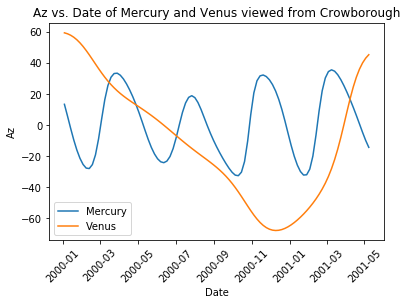

In [176]:
x = planet['Datetime']
y = planet['az']
y2 = planet2['az']
y_label = 'Az'
x_label = 'Date'
planet_name = 'Mercury and Venus'
earth_location = 'Crowborough'
plt.plot(x, y, label="Mercury")
plt.plot(x, y2, label="Venus")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title(f'{y_label} vs. {x_label} of {planet_name} viewed from {earth_location}')
plt.xticks(rotation=45);

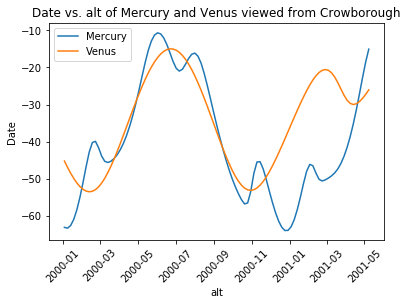

In [150]:
x = planet['Datetime']
y = planet['alt']
y2 = planet2['alt']
y_label = 'alt'
x_label = 'date'
planet_name = 'Mercury and Venus'
earth_location = 'Crowborough'
plt.plot(x, y, label="Mercury")
plt.plot(x, y2, label="Venus")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title(f'{y_label} vs. {x_label} of {planet_name} viewed from {earth_location}')
plt.xticks(rotation=45);

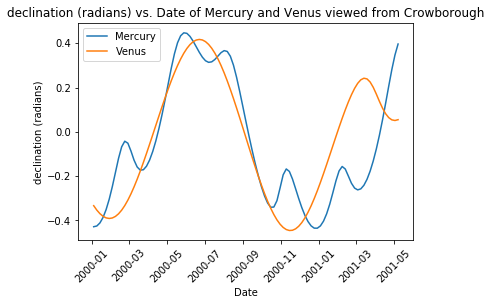

In [175]:
dec1 = [getSkyCoord(row).dec.radian for index, row in planet.iterrows()]
dec2 = [getSkyCoord(row).dec.radian for index, row in planet2.iterrows()]
x = planet['Datetime']
y = dec1
y2 = dec2
y_label = 'declination (radians)'
x_label = 'Date'
planet_name = 'Mercury and Venus'
earth_location = 'Crowborough'
plt.plot(x, y, label="Mercury")
plt.plot(x, y2, label="Venus")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title(f'{y_label} vs. {x_label} of {planet_name} viewed from {earth_location}')
plt.xticks(rotation=45);